In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import scipy.stats
from scipy.sparse import csr_matrix
from skimage import color, data, restoration, img_as_float
from scipy.sparse import diags
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.util import random_noise
from scipy.signal import convolve2d as conv2

In [3]:
def filetoarray(filename,verbose=False):
    file = open(filename, "r")
    txt = file.read()
    txt=txt.split()
    file.close()
    nx=int(txt[1])
    ny=int(txt[2])
    if(verbose):print("nx=",nx,", ny=",ny)
    b=sp.zeros(nx*ny)
    if(verbose):print("size=",b.size)
    for i in range(nx*ny):
            b[i]=float(txt[i+3])
            #print( b[i])
    return [b,nx,ny]

def arraytofile(Img,scale=1,filename="testimg.txt"):
    file= open(filename,"w+")
    a,b=Img.shape
    if len(filename)<4:filename+=".txt"
    else:
        if(filename[-4:]!=".txt"):
            if ('.'in filename) : filename=filename.replace(filename[filename.index("."):], '.txt')
            else:filename+=".txt"
    
    file.write('0 '+str(a)+' '+str(b)+' ')
    for i in range(a):
      for j in range(b):
        file.write(str(Img[i][j]*scale)+' ')
    file.close()
    os.system("txttohbf.exe "+filename)
   
    
    return
  

def filetomatrix(filename,verbose=False):

    file = open(filename, "r")
    txt = file.read()
    txt=txt.split()
    nx=int(txt[1])
    ny=int(txt[2])
    if(verbose):print("nx=",nx,", ny=",ny)
    b=sp.zeros([nx,ny])
    if(verbose):print("size=",b.size,'\n')
    for i in range(nx):
        for j in range(ny):
            b[i,j]=txt[i+3+nx*j]
            if(verbose):print(str(i)+" : ",b[i])
                
    if(verbose):print('\n\n')      
    return b

def artificial_data(nx,ny):
   
    dx=np.zeros([nx*ny])
    dy=np.zeros([nx*ny])
    for i in range(nx):
        for j in range(ny):
            dx[i+nx*j]=i-nx//2
            dy[i+nx*j]=j-ny//2
    return dx,dy



def artificial_data2(nx,ny):
   
    dx=np.zeros([nx,ny])
    dy=np.zeros([nx,ny])
    f =np.zeros([nx,ny])
    for x in range(nx):
        for y in range(ny):
            dx[x,y]=np.cos(x+y**2)-2*x*np.sin(x**2+y)
            dy[x,y]=2*y*np.cos(x+y**2)-np.sin(x**2+y)
            f[x,y]=np.cos(x**2+y) +np.sin(x+y**2)
            
    return f,dx,dy
    


In [4]:
z=np.zeros([1980,1200])
px=np.zeros([1980,1200])
py=np.zeros([1980,1200])

h=8.6e-3

def f(x,y): return  np.sin(2*x+y) 

def dxf(x,y): return 20+2*np.cos(2*x+y)

def dyf(x,y): return 30+np.cos(2*x+y)

for i in range(1980):
    for j in range(1200):
        z[i,j]=f(i*h,j*h)
       # px[i,j]=dxf(i*h,j*h)
        #py[i,j]=dyf(i*h,j*h)
        
arraytofile(z,scale=1,filename="Zbis.txt")
#arraytofile(px,scale=1,filename="PX.txt")
#arraytofile(py,scale=1,filename="PY.txt")

       


In [15]:
b,nx0,ny0=filetoarray("2.txt")
d,nx1,ny1=filetoarray("3.txt")
#print(nx0,nx1 ,ny0,ny1)
assert (nx0==nx1 and ny0==ny1)
nx=nx0
ny=ny0
print("nx=",nx,", ny=",ny)



nx= 1200 , ny= 1920


In [33]:
nx=1000
ny=1000
b,d=artificial_data(nx,ny)

In [34]:
#make A and C matrix

n=nx*ny
a=np.ones(n)
b2=-np.ones(n-1)
i=nx-1
while i<n-nx:
    a[i+1]=0
    b2[i]=0
    i+=nx
a[0]=0
# i=0
# while i<n-nx:
#     a[i+1]=0
#     b[i]=0
#     i+=nx
    

diagonals = [a ,b2]
A=diags(diagonals, [ 0,-1])

#print(A.toarray())


    
a=np.ones(n)
b2=-np.ones(n-nx)
# i=ny-1
# while i<n-ny:
#     a[i]=0
#     b2[i-ny]=0
#     i+=ny
b2[n-nx-1:]=0 
    
a[:nx]=0
a [-1]=0
diagonals = [a,b2 ]
C=diags(diagonals, [ 0, -nx])




In [35]:

def f(x):
    val=0.5*(A@x-b)@(A@x-b)+0.5*(C@x-d)@(C@x-d)
    print("val=", val)
    return val
def jac_f(x):
    return (A.T@A)@x-b.T@A+(C.T@C@x)-d.T@C
def hess_f(x):
    return A.T@A+C.T@C
#print(A.toarray(),"\n\n\n",b,"\n\n\n",C.toarray(),"\n\n\n",d,"\n\n\n")



"""
def f2(z):
    residu=0
    #print("residu x")
    for i in range(1,z.shape[0]-1):
        a=(z[i+1]-z[i-1]-b[i])**2
        #print(i," : " ,a)
        residu+=a
    for i in range(nx,z.shape[0]-nx):
        a=(z[i+1]-z[i-1]-b[i])**2
        #print(i," : " ,a)
        residu+=a
    return residu"""

res= scipy.sparse.linalg.spsolve(A.T@A+C.T@C, A.T@b+C.T@d)


print(res.shape)

(1000000,)


In [10]:
z=sp.zeros([nx,ny])
for i in range(nx):
    for j in range(ny):
        z[i,j]=res[i+nx*j]

[758.06575186 724.06575186 691.06575186 ... 691.06575186 724.06575186
 758.06575186]


In [26]:
x0=sp.random.random(size=n)*50
res=scipy.optimize.minimize(f,x0,jac=jac_f,tol=1e-5)
print(res)
res=res.x

val= 870456.2939983705
val= 867869.8800192446
val= 857581.0023375375
val= 817333.9433674526
val= 670880.9355950052
val= 409830.7518880345
val= 246020.36130251788
val= 408610.3766042476
val= 190551.41461941117
val= 209977.8655586486
val= 166678.60011219353
val= 158365.48831121594
val= 146722.40350257422
val= 133112.0561580995
val= 120159.53118404844
val= 107452.56365208441
val= 93087.70460452617
val= 78336.40259903102
val= 71500.2080931291
val= 63794.95351533758
val= 56604.160025542056
val= 50788.39604246603
val= 44655.586257609495
val= 37965.396305546434
val= 33040.44362572817
val= 30291.45074532798
val= 27264.656968931307
val= 24261.497076352105
val= 22281.191684634592
val= 20305.89290519278
val= 18800.106887057627
val= 17929.44032639287
val= 17280.713659755318
val= 16856.44677186354
val= 16529.25422375813
val= 16464.07383974029
val= 16358.342981613248
val= 16243.661065464521
val= 16333.000617061705
val= 16201.865363339693
val= 16258.143993362279
val= 16189.263624946403
val= 16204.512

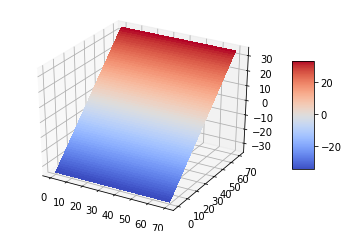

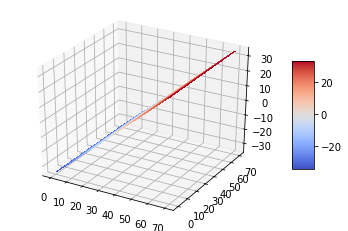

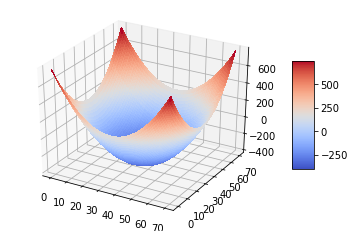

In [11]:



def Plot(res,zero_mean=False,dx=1,dy=1,xmin=0,ymin=0):

    z=sp.zeros([nx,ny])
    for i in range(nx):
        for j in range(ny):
            z[i,j]=res[i+nx*j]

    mean=0.
    if(zero_mean):mean=sp.mean(z)
    Z=z-mean*np.ones_like(z)
    
    X = np.linspace(xmin,xmin+nx*dx, nx)
    Y = np.linspace(ymin,ymin+ ny*dy, ny)
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
         cmap=cm.coolwarm,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    
Plot(b,zero_mean=False,dx=1,dy=1,xmin=0,ymin=0)
Plot(d,zero_mean=False,dx=1,dy=1,xmin=0,ymin=0)
Plot(res,zero_mean=True,dx=1,dy=1,xmin=0,ymin=0)

In [5]:
def test_dx_res(z,b):
    residu=0
    print("residu x")
    for i in range(1,z.shape[0]-1):
        a=(z[i+1]-z[i-1]-b[i])**2
        print(i," : " ,a)
        residu+=a
    print("somme =",residu)
    return residu

def test_dy_res(z,b):
    residu=0
    print("residu y")
    for i in range(nx,z.shape[0]-nx):
        a=(z[i+1]-z[i-1]-b[i])**2
        print(i," : " ,a)
        residu+=a
    print("somme =",residu)
    return residu

for i in range(nx):
    for j in range(ny):
        res[i+nx*j]=0.5*(i**2+j**2)

test_dx_res(res,b)
test_dy_res(res,d)

NameError: name 'res' is not defined

In [100]:
def filetomatrix(filename,verbose=False):
    file = open(filename, "r")
    txt = file.read()
    txt=txt.split()
    file.close()
    nx=int(txt[1])
    ny=int(txt[2])
    if(verbose):print("nx=",nx,", ny=",ny)
    b=sp.zeros([nx,ny])
    if(verbose):print("size=",b.size)
    for i in range(nx):
        for j in range(ny):
            b[i,j]=txt[i+3+nx*j]
            #print( b[i])
    return b



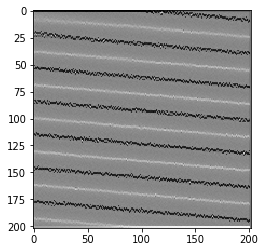

In [122]:
px=filetomatrix('px10.txt',verbose=False)
py=filetomatrix('py10.txt',verbose=False)
#div=np.gradient(px)[0]+np.gradient(py)[1]

pxbis=np.zeros([px.shape[0]+4,px.shape[1]+4])
pxbis[2:-2,2:-2]=px
pybis=np.zeros([py.shape[0]+4,py.shape[1]+4])
pybis[2:-2,2:-2]=py
div=np.zeros([px.shape[0]+2,px.shape[1]+2])

for i in range(1,pxbis.shape[0]-1):
    for j in range(1,pxbis.shape[1]-1):
        div[i-1,j-1]=(pxbis[i+1,j]-pxbis[i-1,j] + pybis[i,j+1]-pybis[i,j-1])/2
plt.imshow(div)




In [5]:
def smooth_heavyside(a):
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[i,j]<.45: a[i,j]= 0
            elif a[i,j]>.55: a[i,j]= 1
            else:  a[i,j]=10*(a[i,j]-0.45)
    return a
    

[[0.49536386 0.53106454 0.54512907 ... 0.49462341 0.52402021 0.55282934]
 [0.50126679 0.53075673 0.52101397 ... 0.50110771 0.51412809 0.54415107]
 [0.51206464 0.52055813 0.51308695 ... 0.50434919 0.51321349 0.49411617]
 ...
 [0.50854643 0.51440788 0.50986779 ... 0.52217439 0.49758    0.51338415]
 [0.49786644 0.50390918 0.52687861 ... 0.50911976 0.51195726 0.4860685 ]
 [0.56012198 0.53900012 0.54162315 ... 0.49457766 0.52818835 0.52762196]]


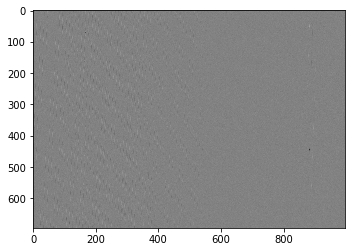

In [103]:

astro =div-np.min(div)#np.ones([100,100])/2 #skimage.data.load('C:\\Users\\Nicolas\\Documents\\python\lena.png')/255#color.rgb2gray(data.astronaut())#
astro/=np.max(astro)
#astro =smooth_heavyside(astro)
print(astro)
astro_orig=astro.copy()
plt.imshow(div)

C:\Users\Nicolas\Anaconda3\lib\site-packages\skimage\restoration\deconvolution.py:389: RuntimeWarning: divide by zero encountered in true_divide
  relative_blur = image / convolve_method(im_deconv, psf, 'same')
C:\Users\Nicolas\Anaconda3\lib\site-packages\skimage\restoration\deconvolution.py:389: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = image / convolve_method(im_deconv, psf, 'same')
C:\Users\Nicolas\Anaconda3\lib\site-packages\skimage\restoration\deconvolution.py:393: RuntimeWarning: invalid value encountered in greater
  im_deconv[im_deconv > 1] = 1
C:\Users\Nicolas\Anaconda3\lib\site-packages\skimage\restoration\deconvolution.py:394: RuntimeWarning: invalid value encountered in less
  im_deconv[im_deconv < -1] = -1
C:\Users\Nicolas\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\Nicolas\Anaconda3\lib\site-packages\numpy\cor

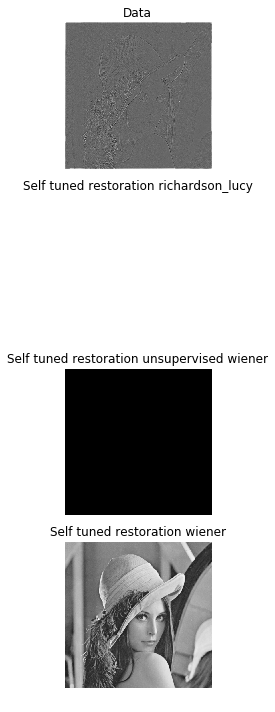

In [8]:


from scipy.signal import convolve2d as conv2
mask=np.array([[0,-1,0],[-1,4.0,-1],[0,-1,0]])
psf = mask
astro=plt.imread("lena.png")
astro=conv2(astro,psf)
deconvolved_rl=restoration.richardson_lucy(image=astro, psf=psf) 
deconvolved_unsupervised_wiener,_=restoration.unsupervised_wiener(astro, psf)
deconvolved_wiener=restoration.wiener(astro, psf,1100)


fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(astro, vmin=astro.min(), vmax=astro.max())
ax[0].axis('off')
ax[0].set_title('Data')
deconvolved_rl=(deconvolved_rl+1)/2
ax[1].imshow(deconvolved_rl, vmin=deconvolved_rl.min(), vmax=deconvolved_rl.max())
ax[1].axis('off')
ax[1].set_title('Self tuned restoration richardson_lucy')

ax[2].imshow(deconvolved_unsupervised_wiener,vmin=deconvolved_unsupervised_wiener.min(),
             vmax=deconvolved_unsupervised_wiener.max())

ax[2].axis('off')
ax[2].set_title('Self tuned restoration unsupervised wiener')


ax[3].imshow(deconvolved_wiener,vmin=deconvolved_wiener.min(),vmax=deconvolved_wiener.max())
ax[3].axis('off')
ax[3].set_title('Self tuned restoration wiener')


fig.tight_layout()

plt.show()
print()

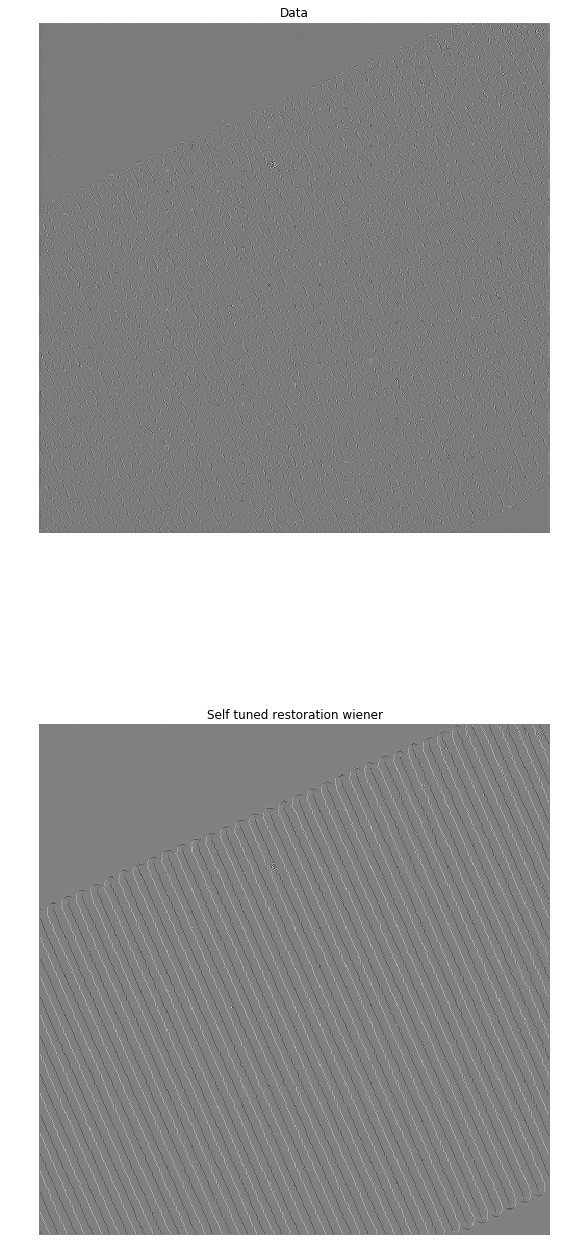

In [9]:
div=filetomatrix("div.txt")

mask=-np.array([[0.,-1.,0.],[-1.,4.0,-1.],[0.,-1.,0.]])
psf = mask
# astro=plt.imread("lena.png")
# astro=conv2(astro,psf)
# deconvolved=restoration.wiener(astro, psf,1100)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 20),
                       sharex=True, sharey=True)

# plt.gray()

# ax[0].imshow(astro, vmin=deconvolved.min(), vmax=deconvolved.max())
# ax[0].axis('off')
# ax[0].set_title('Data')


# ax[1].imshow(deconvolved)
# ax[1].axis('off')
# ax[1].set_title('Self tuned restoration wiener')







astro=div
astro=conv2(astro,psf)
surf=restoration.wiener(astro, psf,1100)



ax[0].imshow(astro, vmin=astro.min(), vmax=astro.max())
ax[0].axis('off')
ax[0].set_title('Data')


ax[1].imshow(surf)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration wiener')



fig.tight_layout()

plt.show()
print()

In [14]:
arraytofile(surf,scale=100,filename="surf.txt")
os.system("txttohbf surf.txt ")

0

In [30]:
def arraytofile(Img,scale=1,filename="testimg.txt"):
    file= open(filename,"w+")
    a,b=Img.shape
    
    file.write('0 '+str(a)+' '+str(b)+' ')
    for i in range(a):
      for j in range(b):
        file.write(str(Img[i][j]*scale)+' ')
    file.close()

#arraytofile(deconvolved_rl,scale=100,filename="deconvolved_rl.txt")
#arraytofile(deconvolved_unsupervised_wiener,scale=100,filename="deconvolved_unsupervised_wiener.txt")

In [75]:

os.system("txttohbf deconvolved_rl.txt ")
os.system("txttohbf deconvolved_wiener.txt ")


0

Estimated Gaussian noise standard deviation = 0.03101558626649794


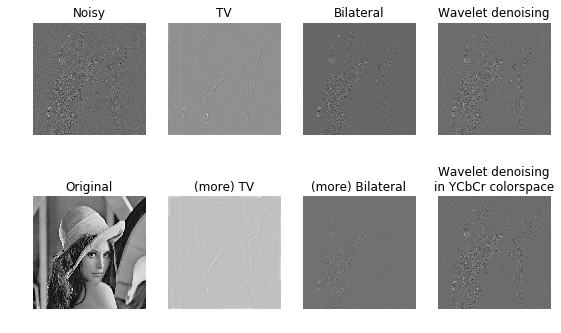

In [120]:



original = plt.imread("lena.png")
original=original-np.min(original)
original/=np.max(original)

noisy = conv2(original,psf)
noisy=noisy-np.min(noisy)
noisy/=np.max(noisy)



fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=False, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print("Estimated Gaussian noise standard deviation = {}".format(sigma_est))

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, multichannel=False))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(noisy+1, sigma_color=0.05, sigma_spatial=15,
                multichannel=False))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, multichannel=False))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, multichannel=False))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(denoise_bilateral(noisy+1, sigma_color=0.1, sigma_spatial=15,
                multichannel=False))
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(denoise_wavelet(noisy, multichannel=False, convert2ycbcr=True))
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

C:\Users\Nicolas\Anaconda3\lib\site-packages\skimage\restoration\deconvolution.py:130: RuntimeWarning: invalid value encountered in true_divide
  balance * np.abs(reg) ** 2)
C:\Users\Nicolas\Anaconda3\lib\site-packages\skimage\restoration\deconvolution.py:138: RuntimeWarning: invalid value encountered in greater
  deconv[deconv > 1] = 1
C:\Users\Nicolas\Anaconda3\lib\site-packages\skimage\restoration\deconvolution.py:139: RuntimeWarning: invalid value encountered in less
  deconv[deconv < -1] = -1


[[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]]


<Figure size 432x288 with 0 Axes>

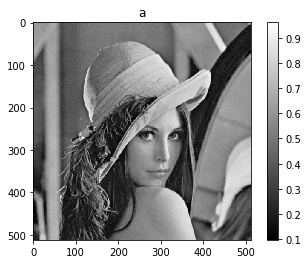

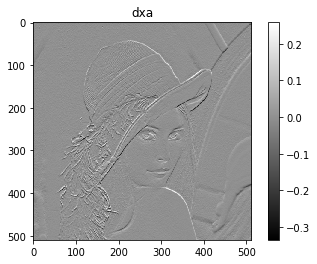

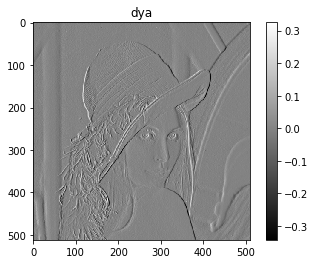

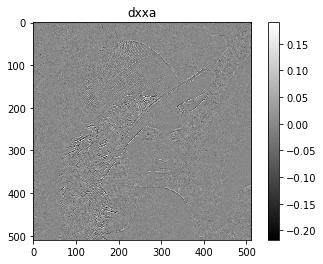

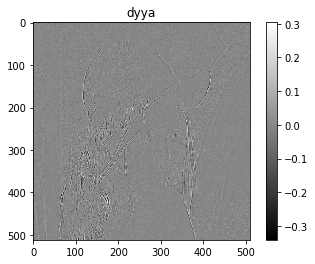

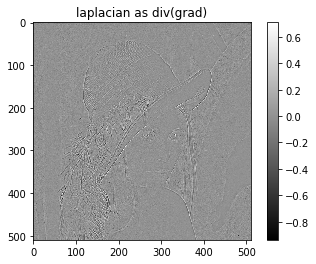

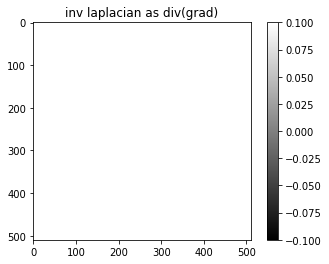

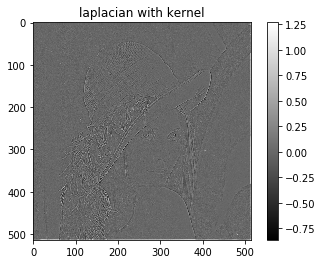

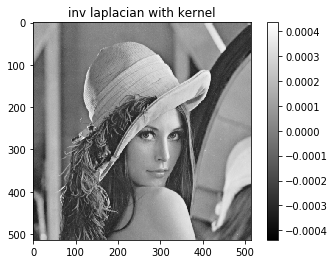

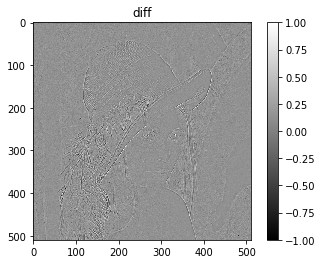

In [11]:


mask=np.array([[0.,-1.,0.],[-1.,4.,-1.],[0.,-1.,0.]])
psf = mask
astro=plt.imread("lena.png")
astro=conv2(astro,psf)
deconvolved=restoration.wiener(astro, psf,1100)




plt.gray()
a=plt.imread("lena.png")
#astro=conv2(astro,psf)
dxa=(a[2:,:]-a[:-2,:])/2
dya=(a[:,2:]-a[:,:-2])/2

fig,ax=plt.subplots()
im=ax.imshow(a)
fig.colorbar(im)
ax.set_title('a')

fig,ax=plt.subplots()
im=ax.imshow(dxa)
fig.colorbar(im)
ax.set_title('dxa')

fig,ax=plt.subplots()
im=ax.imshow(dya)
fig.colorbar(im)
ax.set_title('dya')


dxxa=(a[2:,:]-2*a[1:-1,:]+a[:-2,:])/2
dyya=(a[:,2:]-2*a[:,1:-1]+a[:,:-2])/2

fig,ax=plt.subplots()
im=ax.imshow(dxxa)
fig.colorbar(im)
ax.set_title('dxxa')

fig,ax=plt.subplots()
im=ax.imshow(dyya)
fig.colorbar(im)
ax.set_title('dyya')
print('\n\n')
lapla=np.zeros([a.shape[0]-2,a.shape[1]-2])

for i in range(1,a.shape[0]-1):
    for j in range(1,a.shape[1]-1):
        lapla[i-1,j-1]=a[i-1,j]-2*a[i,j]+a[i+1,j] + a[i,j-1]-2*a[i,j]+a[i,j+1]


fig,ax=plt.subplots()
im=ax.imshow(lapla)
fig.colorbar(im)
ax.set_title('laplacian as div(grad)')

deconvolved=restoration.wiener(lapla, psf,1100)
fig,ax=plt.subplots()
im=ax.imshow(deconvolved)
fig.colorbar(im)
ax.set_title('inv laplacian as div(grad)')

ker=-np.array([[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]])
lapla_ker=conv2(a,ker,mode='full')

fig,ax=plt.subplots()
im=ax.imshow(lapla_ker)

deconvolved=restoration.wiener(lapla_ker, psf,1100)
fig.colorbar(im)
ax.set_title('laplacian with kernel')


fig,ax=plt.subplots()
im=ax.imshow(deconvolved)
fig.colorbar(im)
ax.set_title('inv laplacian with kernel')


fig,ax=plt.subplots()
lapla_ker=lapla_ker[2:-2,2:-2]
lapla=lapla-np.min(lapla)
lapla/=np.max(lapla)
lapla_ker=lapla_ker-np.min(lapla_ker)
lapla_ker/=np.max(lapla_ker)
im=ax.imshow(lapla-lapla_ker)
fig.colorbar(im)
ax.set_title('diff')
print(psf)

shape origin (512, 512) 


|diff max| 2.5411765575408936 


shape lapla (514, 514) 


shape lapla_ker (514, 514) 




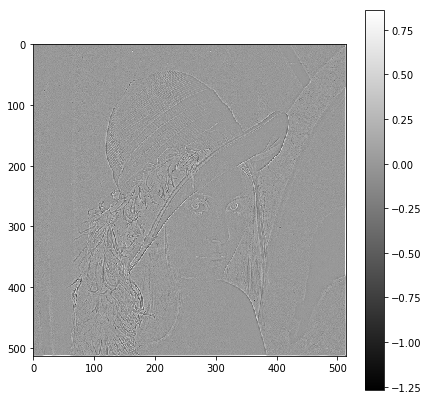

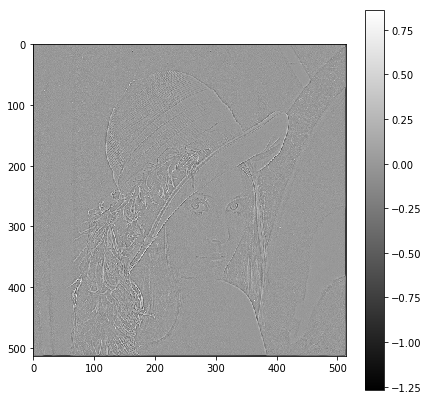

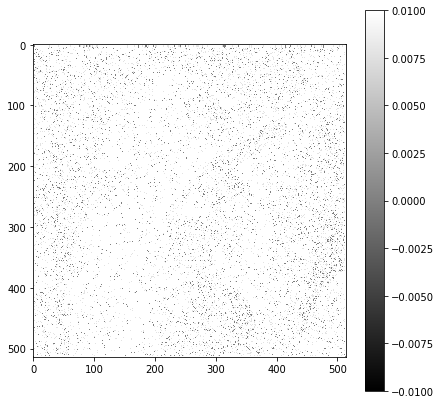

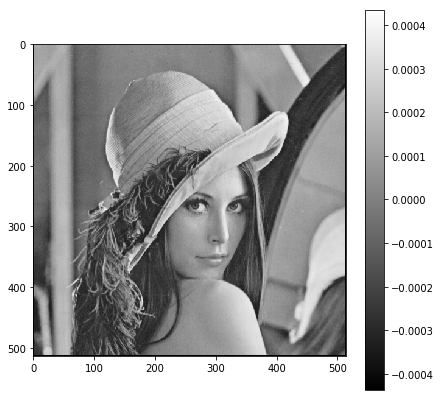

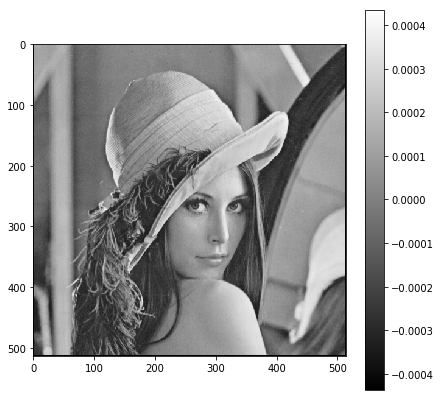

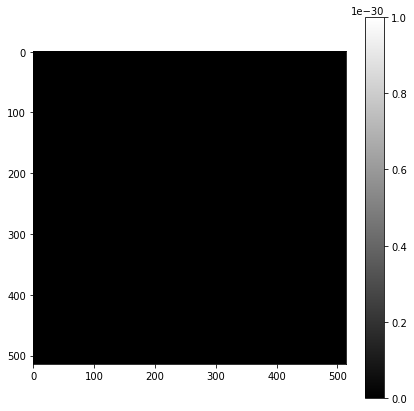

In [107]:
a=plt.imread("lena.png")
print("shape origin", a.shape,'\n\n')
mask=np.array([[0.,-1.,0.],[-1.,4.,-1.],[0.,-1.,0.]])
abis=np.zeros([a.shape[0]+4,a.shape[1]+4])
abis[2:-2,2:-2]=a
lapla=np.zeros([a.shape[0]+2,a.shape[1]+2])
for i in range(1,abis.shape[0]-1):
    for j in range(1,abis.shape[1]-1):
        lapla[i-1,j-1]=(abis[i-1,j]-2*abis[i,j]+abis[i+1,j] + abis[i,j-1]-2*abis[i,j]+abis[i,j+1])
        
        
lapla_ker=conv2(a,mask,'full')
lapla_ker=lapla_ker-np.mean(lapla_ker)
lapla=lapla-np.mean(lapla)
diff=np.abs(lapla_ker-lapla)

#print(lapla,'\n\n\n',lapla_ker)
fig,ax=plt.subplots(figsize=[7,7])
m,M=min(lapla.min(),lapla_ker.min()),min(lapla.max(),lapla_ker.max())
im=ax.imshow(lapla,vmin=m,vmax=M)
fig.colorbar(im)

fig,ax=plt.subplots(figsize=[7,7])
im=ax.imshow(lapla_ker,vmin=m,vmax=M)
fig.colorbar(im)

fig,ax=plt.subplots(figsize=[7,7])
im=ax.imshow(diff,vmin=-1/100,vmax=1/100)
fig.colorbar(im)

fig,ax=plt.subplots(figsize=[7,7])
rec1=restoration.wiener(lapla_ker, mask,1100)
im=ax.imshow(rec1,vmin=rec.min(),vmax=rec.max())
fig.colorbar(im)

fig,ax=plt.subplots(figsize=[7,7])
rec2=restoration.wiener(lapla, -mask,1100)
im=ax.imshow(rec2,vmin=rec.min(),vmax=rec.max())
fig.colorbar(im)

diff_rec=np.abs(rec1-rec2)
fig,ax=plt.subplots(figsize=[7,7])
im=ax.imshow(diff_rec,vmin=0,vmax=1e-30)
fig.colorbar(im)


print("|diff max|" ,diff.max()  ,'\n\n' )


print("shape lapla",lapla.shape,"\n\n")
print("shape lapla_ker",lapla_ker.shape,"\n\n")
#arraytofile(lapla-lapla_ker,scale=1,filename="lapla-lapla_ker.txt")

